In [ ]:
#if you need to install plotting software and numpy for C style arrays
'''
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib.pyplot
'''

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#set up file saving directories
dir_data = "..\\data"
dir_figures = "..\\figures"

#values for all future routines
t, emin, emax = 5, -9, 0
u_c = 10**(1-t)
u_n = 10**(1-t) / 2

### Algorithm 1

In [2]:
def RoundNumber(remainder, m, e, t):
    if remainder >= 5:
        m += 1
        if m == 10**5:
            m //= 10
            e += 1
    return m, e

### Algorithm 2

In [3]:
def TranslateToFloat(x, t, RoundtoNearest = True):
    s, a = np.sign(x), np.abs(x)
    m, e, remainder = 0, 0, 0
    if a > 10**t:
        m = np.floor(a)
        while m >= 10**t:
            remainder = m % 10
            m %= 10
            e += 1
        if RoundtoNearest:
            m, e = RoundNumber(remainder, m, e, t)
        m = s * m
        return (-1)**s * m * 10**(e - t)
    else:
        while a < 10**(t - 1):
            a *= 10
            e -= 1
        remainder = np.floor(10 * (a - np.floor(a)))
        m = np.floor(a)
        if RoundNumber:
            m, e = RoundNumber(remainder, m, e, t)
        m = s * m
        return m, e

### Algorithm 3

In [4]:
def FloatAddition(x, y, t, RoundtoNearest = True):
    """
    x is a floating-point number (m_x, e_x)
    y is a floating point number (m_y, e_y)
    """
    a, b, c, m, e, s, shift, remainder = 0, 0, 0, 0, 0, 0, 0, 0
    shift = x[1] - y[1]
    if shift > 0:
        a = x[0] * 10**shift
        b = y[0]
        e = y[1]
    else:
        a = y[0] * 10**(-shift)
        b = x[0]
        e = x[1]
    c = a + b
    s = np.sign(c)
    c = np.abs(c)
    if c >= 10**t:
        while c >= 10**t:
            remainder = c % 10
            c //= 10
            e += 1
    else:
        while c < 10**(t - 1):
            c *= 10
            e -= 1
    m = int(c)
    if RoundtoNearest:
        m, e = RoundNumber(remainder, m, e, t)
    m *= s
    return m, e

### Algorithm 4

In [5]:
def Accumulation(x):
    """
    x = set of floating point numbers
    
    Return:
    s_n = floating point sum
    """
    n = len(x)
    s = x[0]
    for k in range(1, n):
        s += x[k]
    return s

## Correctness Test

In [6]:
def validateTranslate(t, emin, u_n = u_n):
    delta = u_n * np.random.rand(1) #generate a random float < u_n
    x = np.random.uniform(10**(emin + t - 1), 1, 1)
    xFloat = x * (1 + delta)
    
    error = np.abs((xFloat - x) / x)
    return error

In [7]:
def CorrectnessTest(t, emin, u_n = u_n):
    epsilon = np.finfo(float).eps #to ensure we dont get exact lower bound
    delta = u_n * np.random.rand(1) #generate a random float < u_n
    
    lower_bound = 10**(emin + t - 1)
    
    f1 = (1 - lower_bound)*np.random.rand(1) + lower_bound
    f2 = (1 - lower_bound)*np.random.rand(1) + lower_bound
    
    #translate random numbers to our float representation
    f1_float = TranslateToFloat(f1, t)
    f2_float = TranslateToFloat(f2, t)

    addedFloatParts = FloatAddition(f1_float, f2_float, t)
    addedFloats = addedFloatParts[0] * 10**addedFloatParts[1]
    
    relError = np.abs(addedFloats - (addedFloats * (1 + delta))) / np.abs(addedFloats)
    return relError

In [8]:
def CorrectnessTestArray(N, t, emin, u_n = u_n):
    epsilon = np.finfo(float).eps #to ensure we dont get exact lower bound
    delta = u_n * np.random.rand(1) #generate a random float < u_n
    
    #create N number of randomly generated values within e bounds
    f1 = np.random.uniform(10**(emin + t - 1) + epsilon, 1, N)
    f2 = np.random.uniform(10**(emin + t - 1) + epsilon, 1, N)
    
    #set up array storages for translation values
    f1_float = np.empty((N, 2))
    f2_float = np.empty((N, 2))
    
    #translate random numbers to floats
    for i, f in enumerate(zip(f1, f2)):
        f1_float[i] = TranslateToFloat(f[0], t)
        f2_float[i] = TranslateToFloat(f[1], t)
        
    addedFloats = np.empty(N)
    for i, fl in enumerate(zip(f1_float, f2_float)):
        addedFloat = FloatAddition(fl[0], fl[1], t)
        addedFloats[i] = addedFloat[0] * 10**addedFloat[1]
    
    relError = np.abs((f1 + f2) - addedFloats) / np.abs(f1 + f2)
    return relError

In [9]:
numExper = 10000

transErrors = np.empty(numExper)
relErrors = np.empty(numExper)
for i in range(numExper):
    transErrors[i] = validateTranslate(t, emin)
    relErrors[i] = CorrectnessTest(t, emin)

print("1. Mean error of the translate routine =", np.mean(transErrors))
    
#check to ensure that all values satisfy the relative error bound
print(relErrors[relErrors <= u_n].all()) 
print(np.mean(relErrors))
print(np.var(relErrors))

1. Mean error of the translate routine = 2.5132571435350426e-05
True
2.499121296132837e-05
2.0688633352997766e-10


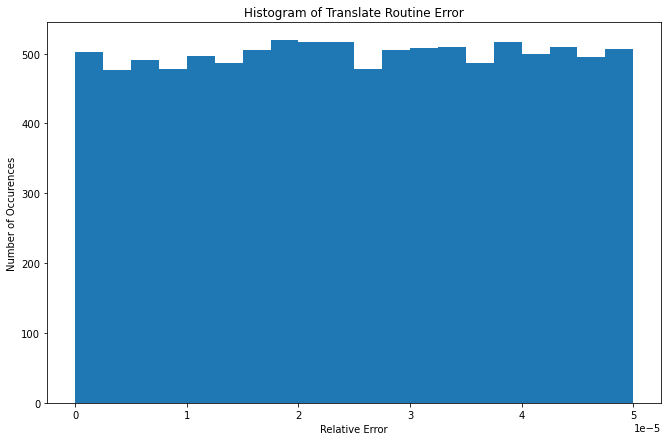

In [23]:
plt.rcParams['figure.figsize'] = (11, 7)
plt.hist(transErrors, 20)
plt.xlabel("Relative Error")
plt.ylabel("Number of Occurences")
plt.title("Histogram of Translate Routine Error")
plt.savefig(os.path.join(dir_figures, "Translation Histogram"))
plt.show()

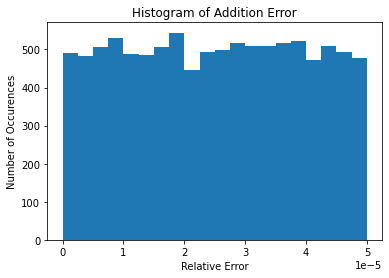

In [20]:
plt.hist(relErrors, 20)
plt.xlabel("Relative Error")
plt.ylabel("Number of Occurences")
plt.title("Histogram of Addition Routine Error")
plt.savefig(os.path.join(dir_figures, "Correctness Histogram"))
plt.show()

As we can see from the histogram and the above code calculation, we can see that the relative error bound is satisfied. Our mean value from over 10000 trials was also less than $u_n$.

## Accumulation Bound

In [12]:
def AccumulationBound(N, t, emin, u_n = u_n):
    #create N randomly generated values within e bounds
    f = np.random.uniform(10**emin, 1, N)

    #set up array storage for translation values
    f_float = np.empty(N)

    #translate to float using routine 2
    for i, x in enumerate(f):
        tempFloat = TranslateToFloat(x, t)
        f_float[i] = tempFloat[0] * 10**tempFloat[1]
        
    regularSum = np.sum(f_float)
    floatSum = Accumulation(f_float)
    actualError = np.abs(floatSum - regularSum)
    
    bound = (N - 1) * np.sum(np.abs(f_float)) * u_n
    #print("|ŝ_n - s_n| =", actualError)
    #print("error bound =", bound)
    return actualError, bound

In [13]:
numFloats = 100
numExper = 1000

#arrays for storage
accumResults = np.empty((numExper,2))
actualErrors = np.empty(numExper)
bounds = np.empty(numExper)

for i in range(numExper):
    accumResults[i] = AccumulationBound(numFloats, t, emin)

for i, (error, bound) in enumerate(accumResults):
    actualErrors[i] = error
    bounds[i] = bound
    
print("Error <= Bound? ", actualErrors.all() < bounds.all())
print(np.mean(actualErrors))
print(np.mean(bounds))

Error <= Bound?  True
1.0821565865626325e-14
0.24785243020792092


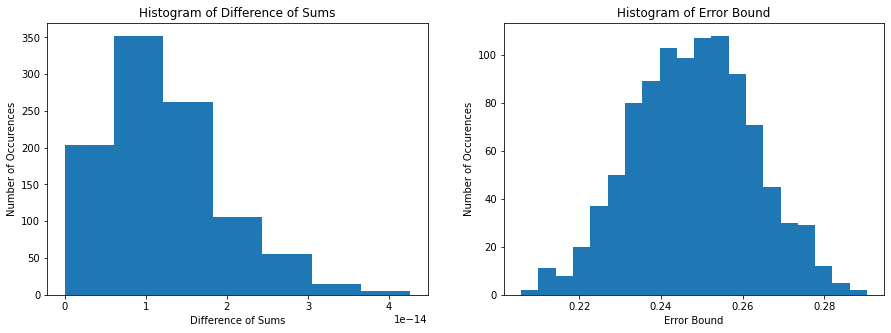

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(actualErrors, 7)
axs[0].set_xlabel("Difference of Sums")
axs[0].set_ylabel("Number of Occurences")
axs[0].set_title("Histogram of Difference of Sums")

axs[1].hist(bounds, 20)
axs[1].set_xlabel("Error Bound")
axs[1].set_ylabel("Number of Occurences")
axs[1].set_title("Histogram of Error Bound")

plt.savefig(os.path.join(dir_figures, "Accumulation Histogram"))
plt.show()

The error bound holds as we can see from both the mean of the calculated values and the histogram above; however, this is not a tight bound with respect to the actual error.

## Conditioning Analysis

In [15]:
def ConditioningAnalysis(N, t, emin,  u_n = u_n):
    x = np.random.uniform(10**(emin + t - 1), 1, N).astype('double')
    
    #set up array storage for translation values
    xi = np.empty(N)

    #translate to float using routine 2
    for i, x_i in enumerate(x):
        tempFloat = TranslateToFloat(x_i, t)
        xi[i] = tempFloat[0] * 10**tempFloat[1]
    
    p = np.empty(N, dtype = np.float64)
    for i, xi in enumerate(x):
        p[i] = np.random.uniform(0, xi * u_n, 1).astype('double')
    
    def perturb(x, N):
        p = np.empty(N)
        for i, xi in enumerate(x):
            p[i] = np.random.uniform(10**(emin + t - 1), xi * u_n, 1).astype('double')
        return p
    
    '''
    for i in range(totalRuns):
        p = perturb(x, N)
        numerator = np.abs(np.sum(x) - np.sum(x + p))
        denominator = np.abs(np.sum(x))
        c_rel[i] = (numerator/denominator) * (np.sum(np.abs(x))/np.sum(np.abs(p)))
    '''
    
    numerator = np.abs(np.sum(x) - np.sum(x + p))
    denominator = np.abs(np.sum(x))
    c_rel = (numerator/denominator) * (np.sum(np.abs(x))/np.sum(np.abs(p)))
    
    exactDoubleSum = np.sum(x)
    exactFloatSum = np.sum(xi)
    relError = np.abs((exactDoubleSum - exactFloatSum) / exactDoubleSum)
    
    return c_rel, relError

In [16]:
setSize = 100
trials = 1000
conditionNumbers = np.empty(trials)
relativeErrors = np.empty(trials)

for i in range(trials):
    conditionNumbers[i], relativeErrors[i] = ConditioningAnalysis(setSize, t, emin)
relConditionNumber = np.max(conditionNumbers)

print("K_rel =", relConditionNumber)
print("Mean relative error =", np.mean(relativeErrors))

K_rel = 1.0000000000165967
Mean relative error = 0.990172609946898


As we can see from the above, the relative error between two exact sums is consistent with the approximated condition number.

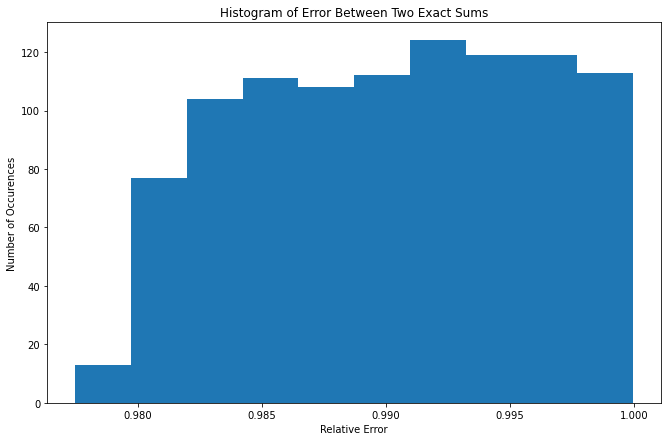

In [33]:
plt.hist(relativeErrors)
plt.xlabel("Relative Error")
plt.ylabel("Number of Occurences")
plt.title("Histogram of Error Between Two Exact Sums")
plt.savefig(os.path.join(dir_figures, "Condition Number Histogram"))
plt.show()